<a href="https://colab.research.google.com/github/MatheusOrange211/Sirio_Libanes_ICU_Prediction/blob/main/Visualizando_os_dados_Sirio_Libanes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploração dos dados - Buscando entender um pouco mais o que temos

Para entendermos melhor como nosso conjunto de dados é e qual modelo ir implementando, primeiro devemos entender o que temos de dados. Afinal, saber quais dados são faltantes, quais informações podemos ter que realmente ajudarão, dentre outras coisas, serão de caráter fundamental para o modelo obter uma boa performance. Abaixo, lhe mostro o que possuímos e como o modelo que apliquei auxiliará no dia-a-dia do hospital, no que tange a tomada de decisões.

Primeiramente importo as bibliotecas que serão usadas nesta parte do projeto. Elas contêm ferramentas necessárias para a exploração dos dados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import missingno as msno

sns.set()

#DADOS

In [2]:
dados = pd.read_excel("https://github.com/MatheusOrange211/Sirio_Libanes_ICU_Prediction/raw/main/data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")

#FUNÇÕES 

Essa função retorna um resumo simples do que temos no nosso conjunto de dados. Informações como quantidade de linhas e colunas e quantidade totais de valores Not a Number (Nan), que causam muitos problemas na hora de maninpular dados, são apresentados.

In [3]:
def resume_dataframe(dataset  : pd.DataFrame):
  
  data_nan = dataset.isnull().any().any()
  dataset_types = list (set(dataset.dtypes.values))
  print("################ RESUMO BÁSICO ####################\n")
  print(f"Quantidade de instâncias: {len(dados)} (linhas)\nQuantidade de Atributos: {len(dados.columns)} (colunas)\n")

  if data_nan:
    print(f"Possui dados NaN ? {data_nan}\nQuantidade de NaN totais: {dataset.isnull().sum().values.sum()}\n")

  print(f"Tipos de  dados que temos :\n{dataset_types}\n")
  print("##################################################\n")

Essa função é responsável por gerar uma tabela detalhada e formatada sobre determinada coluna. As informações que ela gera ajudam a compreeender mais sobre o comportamento de terminada coluna e sua distribuição a longo da tabela.


In [4]:
def formated_table(dataset : pd.DataFrame, dicionario : dict  = None, title_index :str = None):
  frequency = dataset.value_counts()
  percentage = (dataset.value_counts(normalize=True) * 100).round(3)
  final_dataset = pd.DataFrame({"Frequencia":frequency,"Porcentagem":percentage})

  if dicionario:
    final_dataset.rename(index = dicionario, inplace = True)
  
  if title_index:
    final_dataset.rename_axis(title_index,axis=1,inplace=True)
  
  return final_dataset

A função abaixo será responsável por cruzar duas colunas de dados. Dela podemos averiguar questões como:
Quantos porcento das pessoas que forma admitidas em um intervalo de até 2 horas necessitaram de UTI? ou até mesmo, das pessoas que foram internadas, quantos porcento foram admitidas num intervalo de mais de 12 horas.

In [5]:
def crosstab_data(dataset1: pd.DataFrame, dataset2:pd.DataFrame,normal:str = "index",dicio1:dict= None, dicio2: dict = None):
    dataframe = (pd.crosstab(dataset1,dataset2,normalize=f"{normal}")*100).round(2)
    
    if dicio1:
      dataframe.rename(index=dicio1,inplace=True)

    if dicio2:
      dataframe = dataframe.rename(columns=dicio2)
    
    return dataframe

#PARTINDO PARA A ANÁLISE

Pra começar, vamos ver o que temos logo de cara no dataset. Compreender sua composição é de fundamental importância para uma boa tomada de decisão.

In [6]:
dados.head(3)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.59322,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0,-0.162393,-0.5,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.59322,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0,-0.025641,-0.5,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0


Acima, imprimimos apenas as 3 primeiras linhas do DataFrame. A quantidade de colunas é grande e podemos analisar isso ou pouco melhor abaixo

In [7]:
resume_dataframe(dados)

################ RESUMO BÁSICO ####################

Quantidade de instâncias: 1925 (linhas)
Quantidade de Atributos: 231 (colunas)

Possui dados NaN ? True
Quantidade de NaN totais: 223863

Tipos de  dados que temos :
[dtype('int64'), dtype('float64'), dtype('O')]

##################################################



Temos **1925** linhas e **231** colunas no total. Nosso dataframe `dados` (nome que darei para o conjunto de dados original), possui valores NaN em um total de **22363** células. Isso significa que precisaremos tratar estes dados e buscar tratar estes valores ausentes para quando treinado, não termos problemas de desemepenho no modelo. Contudo, neste Notebook, nos antentaremos apenas em explorar os dados. Por fim, temos uma lista de informções que nos indicam que temos  dados do tipo **Inteiro** (*int64*), tipo **Object** (*o*) e tipo **Real** ou **Float**, em inglês (*float64*).
Para fins de conhecimento temos que para tipo **Object**:
>O Object tipo de dados pode apontar para dados de qualquer tipo de dados, incluindo qualquer instância de objeto que seu aplicativo reconhece. ([Link para Leitura](https://docs.microsoft.com/pt-br/dotnet/visual-basic/language-reference/data-types/object-data-type#:~:text=O%20Object%20tipo%20de%20dados,objeto%20que%20seu%20aplicativo%20reconhece.))

##Compreendendo um pouco mais sobre Not a Number - NaN

**Not a Number** ou apenas **NaN** é definido como:
>  Um valor ou símbolo usado nas linguagens de programação para representar um valor numérico indefinido ou irrepresentável. Seu uso sistemático foi introduzido pelo padrão IEEE 754 em 1985, junto com a representação de outras quantidade não finitas tais como infinitos ([link para leitura](https://pt.wikipedia.org/wiki/NaN))

Na análise de dados, NaN devem ser tratados com muita atenção. Dados Ausentes, conforme lista Matt Harrison, autor de *Machine Learning - Guia de Referência Rápida*, podem ser lidados da seguinte forma:
* Removendo qualquer linha que contenha dados ausentes;
* Removendo qualquer coluna que contenha dados ausentes;
* Imputar dados aos valores ausentes;
* Criar uma coluna  para informar que os dados estavam ausentes.

Contudo, em cada caso, devemos avaliar bem a forma como iremos tratar esse tipo de dados. Apenas descartar, por exemplo, todas as linhas com dados ausentes, pode reduzir drasticamente nosso dataframe, e isso pode impactar negativamente o desempenho do nosso modelo.<br>
Vamos então explorar estes dados NaN, e ver qual a sua porcentagem em relação as colunas.

In [108]:
# msno.matrix(dados.sample(500),figsize=(15,8)).get_figure();

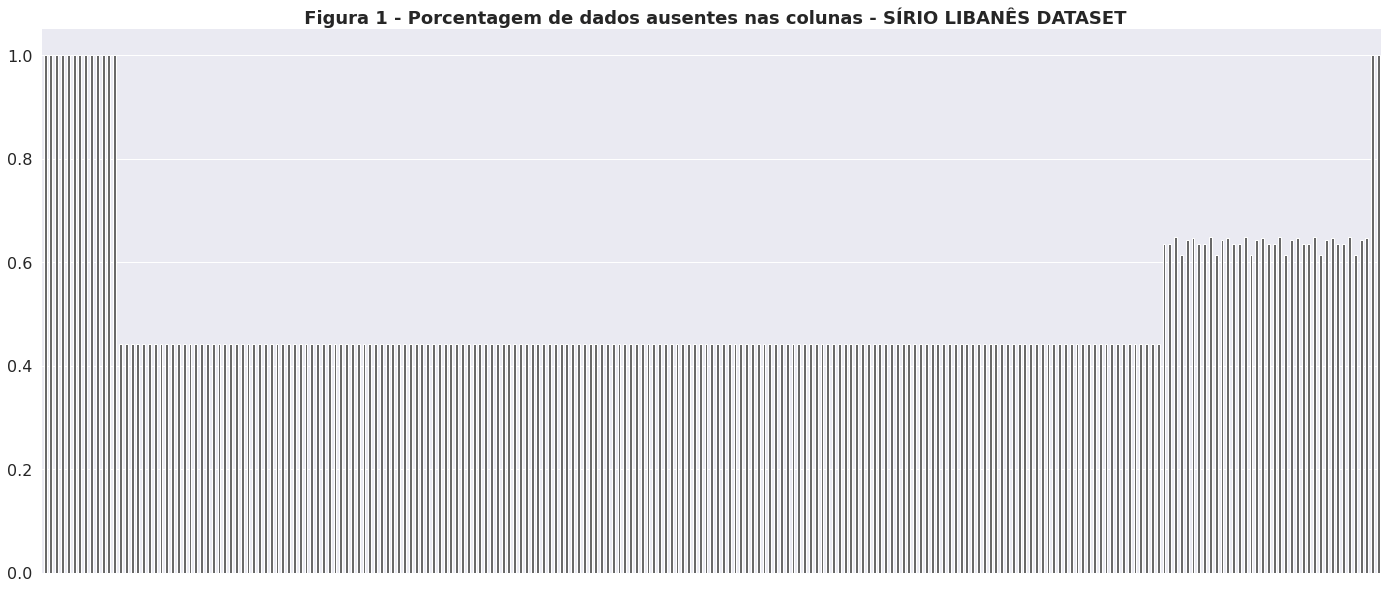

In [8]:
grafico_dados_faltantes = msno.bar(dados.sample(500))
plt.title(" Figura 1 - Porcentagem de dados ausentes nas colunas - SÍRIO LIBANÊS DATASET",
          size=18,weight='bold')

grafico_dados_faltantes.get_figure();

Com a ajuda da biblioteca Missingno, podemos analisar nosso conjunto de dados de forma global e ver como todas as colunas se comportam em relação a quantidade de dados ausentes. Abaixo temos uma visão geral que mostra que grande parte das colunas apresentam apenas 40% de dados, sendo o resto em sua maioria, valores NaN.

Tendo essas informações já temos uma boa noção de que simplesmente descartar linhas e/ou colunas com dados faltantes não será uma boa ideia. O ideal será imputar valores neste caso. Isso abordamos em outro momento. Continuemos explorando nossos dados. Vejamos quais colunas possuem dados faltantes:

In [9]:
print(f"Quantidade de Colunas com dados faltantes: {dados.isna().any().sum()}")

Quantidade de Colunas com dados faltantes: 225


Abaixo, vemos mais especificamente quais são essas colunas

In [10]:
faltantes = dict(dados.isnull().any())
col_faltantes = []

for  i in faltantes.items():
  if i[1] == True:
    col_faltantes.append(i[0])

col_faltantes

['DISEASE GROUPING 1',
 'DISEASE GROUPING 2',
 'DISEASE GROUPING 3',
 'DISEASE GROUPING 4',
 'DISEASE GROUPING 5',
 'DISEASE GROUPING 6',
 'HTN',
 'IMMUNOCOMPROMISED',
 'OTHER',
 'ALBUMIN_MEDIAN',
 'ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'ALBUMIN_DIFF',
 'BE_ARTERIAL_MEDIAN',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_ARTERIAL_DIFF',
 'BE_VENOUS_MEDIAN',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BE_VENOUS_DIFF',
 'BIC_ARTERIAL_MEDIAN',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_ARTERIAL_DIFF',
 'BIC_VENOUS_MEDIAN',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BIC_VENOUS_DIFF',
 'BILLIRUBIN_MEDIAN',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BILLIRUBIN_DIFF',
 'BLAST_MEDIAN',
 'BLAST_MEAN',
 'BLAST_MIN',
 'BLAST_MAX',
 'BLAST_DIFF',
 'CALCIUM_MEDIAN',
 'CALCIUM_MEAN',
 'CALCIUM_MIN',
 'CALCIUM_MAX',
 'CALCIUM_DIFF',
 'CREATININ_MEDIAN',
 'CREATININ_MEAN',
 'CREATININ_MIN',
 'CREATIN

São essas, as coluna que estão com dados faltantes e que precisarão ser tratadas.

##Período de Admissão de Paciente e Quantidade de Pacientes que necessitam de UTI

Uma coisa muito importante para o andamento do projeto é entender sobre as chamadas "janelas" ou "windows" que o dataset possui. Essa coluna possui informações referentes ao tempo que o paciente deu entrada no hospital. Quanto mais cedo nosso modelo conseguir prever, melhor será para os profissionais de saúde e equipe médica em relação ao tratamento, quanto para o paciente, o principal beneficiado por um atendimento e tratamento rápido que pode lhe custar a vida se negado. Vejamos um pouco sobre essa coluna e o que temos dela no geral

In [11]:
intervalo_admissao = {"0-2": "Até 2h","2-4":"De 2h até 4h","4-6": "De 4h até 6h",	
                      "6-12": "De 6h até 12h","ABOVE_12":"Acima de 12h"}
                      
formated_table(dados['WINDOW'],dicionario=intervalo_admissao)

,Frequencia,Porcentagem
De 6h até 12h,385,20.0
Acima de 12h,385,20.0
De 4h até 6h,385,20.0
De 2h até 4h,385,20.0
Até 2h,385,20.0


A distribuição dos dados para a coluna `WINDOW` apresenta-se precisamente dividida. Possuímos os cenários bem definidos e a partir deles, podemos buscar treinar nossos modelos em cenários variados.

Contudo, outro ponto importante é entender como ficou a necessidade internação na UTI por horário de Admissão. A pergunta é:
**Dos Pacientes que foram admitidos em um intervalo X, quantos porcento precisaram de UTI?**

Primeiros, vejamos a coluna `UCI`. O que temos nela são os dados de pacientes que vão para UTI. os valores usados são 0 e 1.

In [12]:
pacientes_uti_freq_porcentagem = formated_table(dados['ICU'])
pacientes_uti_freq_porcentagem

,Frequencia,Porcentagem
0,1410,73.247
1,515,26.753


gráficamente temos:

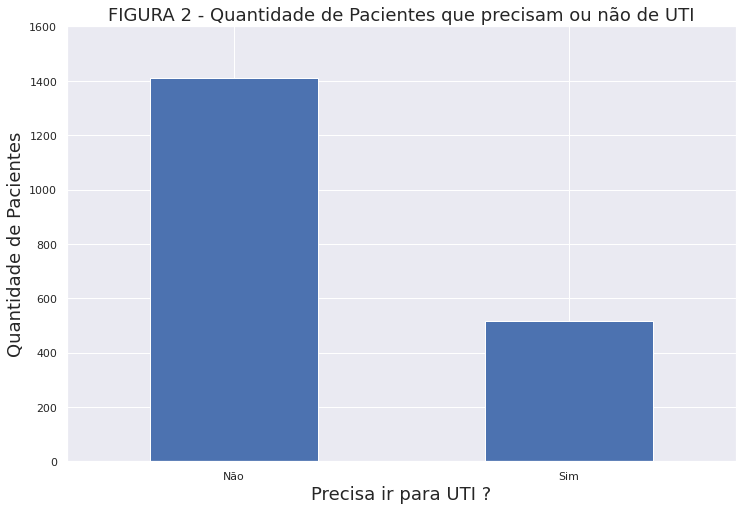

In [66]:
grafico_qtd_uti = dados['ICU'].value_counts().plot(kind='bar',figsize=(12,8))
plt.ylim(0,1600)
plt.title("FIGURA 2 - Quantidade de Pacientes que precisam ou não de UTI",size=18)
plt.ylabel("Quantidade de Pacientes",size=18)
plt.xlabel('Precisa ir para UTI ?',size=18)
plt.xticks([0,1],["Não","Sim"],rotation = 0)

plt.show()

Temos uma quantidade maior de valores iguais a zero. Partiremos do pontos então que os valores iguais a zero são os pacientes que não precisam ser internados, e iguais a 1, como os pacientes que foram internados. Resumidamente, mais de **73%** dos pacientes não precisaram de UTI, enquanto cerca de **26.75 %** precisaram.

Voltando então para a análise das janelas de admissão de paciente.

In [21]:
dicio_uti = {0:"nao_precisa_de_uti",1:"precisa_de_uti"}


janela_por_uti = crosstab_data(dados['WINDOW'],dados['ICU'],
                               normal='index',
                               dicio1=intervalo_admissao,
                               dicio2= dicio_uti)
janela_por_uti

ICU,nao_precisa_de_uti,precisa_de_uti
WINDOW,,
Até 2h,91.69,8.31
De 2h até 4h,84.68,15.32
De 4h até 6h,74.29,25.71
De 6h até 12h,66.23,33.77
Acima de 12h,49.35,50.65


Acima temos que: **Dos pacientes admitidos em uma janela de até 2 horas, 91.69% não precisou ser internada em UTI's**. Contudo, se formos analisando com o passar das horas, vai ficando claro que esse quadro vai mudando. **Quanto mais tarde os pacientes foram admitidos, mais foi crescendo a necessidade de ser internado na UTI**, até que chegamos ao quadro de pacientes que foram admitidos em uma janela **acima de 12 horas**. Nela, **mais de 50%** dos pacientes precisaram ir para UTI. Podemos representar esse comportamento em um gráfico para ficar mais claro.

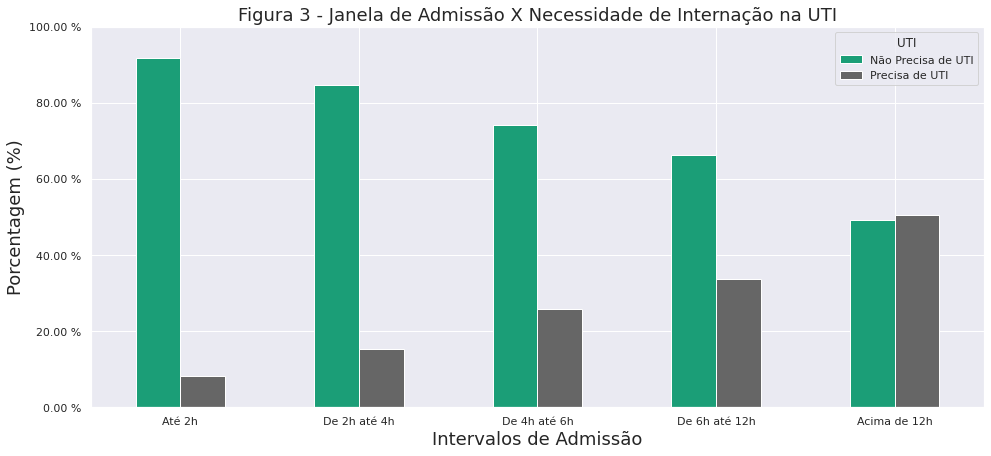

In [22]:
fig = janela_por_uti.plot(kind='bar', figsize=(16,7),colormap = 'Dark2')
fig.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f} %"))
plt.title("Figura 3 - Janela de Admissão X Necessidade de Internação na UTI",size=18)
fig.set_ylabel("Porcentagem (%)",size=18)
fig.set_xlabel("Intervalos de Admissão",size=18)
plt.xticks(rotation=0)
plt.ylim(0,100)

plt.legend(title='UTI',labels=['Não Precisa de UTI','Precisa de UTI'])

fig;


Acima, temos de forma mais destacada o comportamento apresentado por pacientes com janela de admissões mais tardias. A necessidade de internação em UTI vai aumentando.

Agora vejamos a distribuição das pessoas internadas ou não em relação ao tempo de admissão existente.

In [23]:
uti_por_janelas = crosstab_data(dados['WINDOW'],dados['ICU'],
                               normal='columns',
                               dicio1=intervalo_admissao,
                               dicio2= dicio_uti)
uti_por_janelas

ICU,nao_precisa_de_uti,precisa_de_uti
WINDOW,,
Até 2h,25.04,6.21
De 2h até 4h,23.12,11.46
De 4h até 6h,20.28,19.22
De 6h até 12h,18.09,25.24
Acima de 12h,13.48,37.86


temos que mais 37 % das pessoas que estão na UTI são do grupo de admissão acima de 12 horas.

Continuando na exploração, temos a coluna `AGE_PERCENTIL`, que separa os pacientes em grupos de idade. Vejamos como ela está distribuida no dataset, assim como sua frequência e como ela se relaciona com outros dados.

In [17]:
idades_percentil = formated_table(dados['AGE_PERCENTIL'])
idades_percentil

,Frequencia,Porcentagem
20th,215,11.169
10th,205,10.649
30th,205,10.649
40th,200,10.390
70th,195,10.130
80th,190,9.870
50th,190,9.870
60th,185,9.610
Above 90th,185,9.610
90th,155,8.052


A maioria das pessoas que compõe o dataset são da faixa etária de  20 anos, seguido de pacientes do grupo de 30 anos.

In [24]:
crosstab_data(dados['AGE_PERCENTIL'],dados['ICU'],normal='columns',dicio2=dicio_uti)

ICU,nao_precisa_de_uti,precisa_de_uti
AGE_PERCENTIL,,
10th,12.70,5.05
20th,13.19,5.63
30th,11.35,8.74
40th,11.77,6.60
50th,10.28,8.74
60th,9.08,11.07
70th,9.01,13.20
80th,9.08,12.04
90th,6.52,12.23


Quando analisamos agora em relação a quem foi internado na UTI e quem não foi, notamos que os grupos de idades apartir dos 60 anos são a maioria.

##Compreendendo um pouco sobre as Colunas listadas

Em nosso conjunto de dados, temos algumas colunas de dados que trazem informações referente a doenças que determinado paciente possui ou não. Conhecer um pouquinho sobre estas doenças ajuda a entender os impactos que podem gerar em pacientes que necessitem de UTI por conta do Coronavírus.<br>
Começando então pela coluna `HTN` que refere-se a **Hipertensão** (*entendida como a pressão arterial acima de 14/9 e é considerada grave quando a pressão está acima de 18/12*). Conforme matéria da Revista [Veja](https://saude.abril.com.br/medicina/por-que-a-hipertensao-aumenta-o-risco-de-complicacoes-do-coronavirus/), a Hipertensão pode agravar o quadro de pacientes que foram infectados pela covid-19. Como aponta a própria matéria:
> Em um dos trabalhos, feito com mais de mil pacientes, dos 173 que foram acometidos de maneira severa pela Covid-19, 23% tinham pressão alta e 16%, diabetes. Em outro, de 140 internados por causa da Covid-19, 30% possuíam hipertensão e 12%, a glicemia cronicamente elevada. [...] 

Ainda segundo a mesma reportagem, temos que:

> Para infectar as células, o Sars-Cov-2 utiliza a enzima conversora de angiotensina 2, chamada de ECA-2, presente nas células de pulmão, rins e outros órgãos. E alguns remédios usados pelos hipertensos elevam o nível dessas enzimas”, explica a cardiologista Ludhmila Abrahão Hajjar, diretora de Ciência, Tecnologia e Inovação da Sociedade Brasileira de Cardiologia (SBC). 

Isso significa que devemos manter uma atenção a esses dados referentes a hipertensão, sendo de grande importância pra um treino de modelo de classificação, talvez. Presumindo então que em nossos dados os valores tenham o seguite significado:

* 0 = Sem Hipertensão
* 1 = Possui Hipertensão

Vejamos como é a relação de pessoas que possuem ou não hipertensão e a necessidade de UTI

In [30]:
dicio_hipertensao ={0:"nao_possui_hipertensao",1:"possui_hipertensao"}


rel_hipertensao_uti = crosstab_data(dados['HTN'],dados['ICU'], dicio1 = dicio_hipertensao, dicio2 = dicio_uti)
rel_hipertensao_uti

ICU,nao_precisa_de_uti,precisa_de_uti
HTN,,
nao_possui_hipertensao,77.10,22.90
possui_hipertensao,58.68,41.32


Das pessoas que não possuem hipertensão, apenas **22.90%** necessitaram de internação em um leito de UTI. Por outro lado, dos pacientes que sofrem da doença, cerca de **41%** precisaram ser internados. Essa **Diferença** de **18%** indica o impacto que a hipertensão causa, junto da covid-19 em pacientes. Essa coluna pode ser de grande importância para o modelo e análise de resultados.

Nas colunas, temos uma coluna que nos diz quais pacientes são 
**IMUNOCOMPROMETIDOS** (coluna `IMMUNOCOMPROMISED`). Temos por definição que:
>Os pacientes imunocomprometidos são aqueles cujos mecanismos normais de defesa contra infecção estão comprometidos. Esses pacientes podem incluir, entre outros, receptores de transplante e de implante, queimados, portadores do vírus da imunodeficiência humana (HIV) e indivíduos com câncer. Como o sistema imune do paciente torna-se mais e mais comprometido, os organismos menos virulentos progressivamente se tornam mais perigosos, deixando os pacientes com graves defeitos imunológicos mais suscetíveis a um número e uma variedade maior de doenças infecciosas. (Referência: [Medicina Net](https://www.medicinanet.com.br/conteudos/qualidade-e-seguranca/5355/pacientes_imunocomprometidos.htm))

Isso significa que por estarem nesta situação, tornam-se alvos fáceis para o Coronavírus. Em nosso conjunto de dados, temos, assumindo os significados os seguintes valores:
* 0 = Não é Imunocomprometido;
* 1 = É Imunocomprometido;


In [51]:
dicio_imunocomprometido = {0: "nao_e_imunocomprometido", 1: "e_imunocomprometido"}

imunocomprometido_freq_porcentagem = formated_table(dados['IMMUNOCOMPROMISED'],dicionario = dicio_imunocomprometido)
imunocomprometido_freq_porcentagem

,Frequencia,Porcentagem
nao_e_imunocomprometido,1616,84.167
e_imunocomprometido,304,15.833


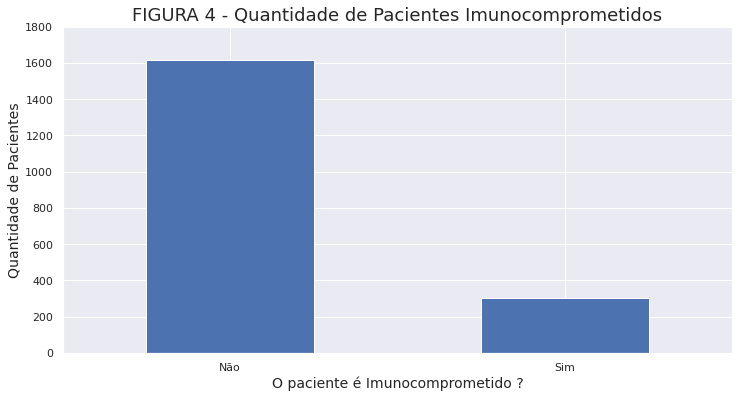

In [68]:
imunocomprometido_freq_porcentagem['Frequencia'].plot(kind='bar',figsize=(12,6))

plt.title("FIGURA 4 - Quantidade de Pacientes Imunocomprometidos",size=18)
plt.ylabel("Quantidade de Pacientes",size=14)
plt.xlabel('O paciente é Imunocomprometido ?',size=14)
plt.xticks([0,1],["Não","Sim"],rotation = 0)
plt.ylim(0,1800)
plt.show()

Mais de **84%** dos pacientes não são Imunocomprometidos.<br>

Mas a pergunta agora é: **Com isso é refletido na ocupação de UTI's ?**

In [73]:
crosstab_data(dados['IMMUNOCOMPROMISED'],dados['ICU'],dicio1=dicio_imunocomprometido,dicio2 = dicio_uti)

ICU,nao_precisa_de_uti,precisa_de_uti
IMMUNOCOMPROMISED,,
nao_e_imunocomprometido,73.45,26.55
e_imunocomprometido,71.71,28.29


Imunocomprometidos, por mais que tenham toda a questão de estarem com os mecanismos de defesa mais frageis, não representam uma grande quantidade de ocupações em leitos de UTI. Os valores até se assemelham com os de pacientes de não imunocomprometidos (mesmo sendo um pouco menor).

Uma outra coisa interessante a se fazer, é analisar algumas colunas de forma aleatória. A ideia aqui é pegar 12 colunas referentes as médias de:

* ALBUMINA - responsável principalmente por manter constante os níveis de líquido nos vasos sanguíneos;
* CÁLCIO - responsável pela formação e desenvolvimento dos ossos e dentes;
* GLICOSE - função primordial é de fornecer energia aos organismos vivos;
* HEMOGLOBINA - responsável pela coloração vermelha do sangue;
* LEUCÓCITOS -  têm como função a defesa contra organismos estranhos;
* POTÁSSIO - é necessário para o funcionamento normal das células, nervos e músculos;
* FREQUÊNCIA CARDIACA - a velocidade do ciclo cardíaco medida pelo número de contrações do coração por minuto;
* FREQUÊNCIA RESPIRATÓRIA -  é a designação dada em fisiologia animal e em medicina ao número de ciclos respiratórios que um animal completa num lapso específico de tempo;
* TEMPERATURA;
* SATURAÇÃO DE OXIGÊNIO - saturação de oxigênio do sangue, ou seja a porcentagem de oxigênio que está sendo transportada na circulação sanguínea;
* ITU - no caso, ICU.

In [78]:
dados_sanguineos_respiracao = dados[['ALBUMIN_MEAN','CALCIUM_MEAN','CALCIUM_MEAN','GLUCOSE_MEAN','HEMOGLOBIN_MEAN',
      'LEUKOCYTES_MEAN','POTASSIUM_MEAN','HEART_RATE_MEAN','RESPIRATORY_RATE_MEAN',
      'TEMPERATURE_MEAN','OXYGEN_SATURATION_MEAN','ICU']]

Quantidade de valores NaN nas colunas

In [79]:
dados_sanguineos_respiracao.isna().sum()

ALBUMIN_MEAN              1104
CALCIUM_MEAN              1104
CALCIUM_MEAN              1104
GLUCOSE_MEAN              1104
HEMOGLOBIN_MEAN           1104
LEUKOCYTES_MEAN           1104
POTASSIUM_MEAN            1104
HEART_RATE_MEAN            685
RESPIRATORY_RATE_MEAN      748
TEMPERATURE_MEAN           694
OXYGEN_SATURATION_MEAN     686
ICU                          0
dtype: int64

Usaremos um Correlograma, uma variante de um Mapa de Calor (Heat Map), para analisarmos se há correlações entre as colunas selecionadas.

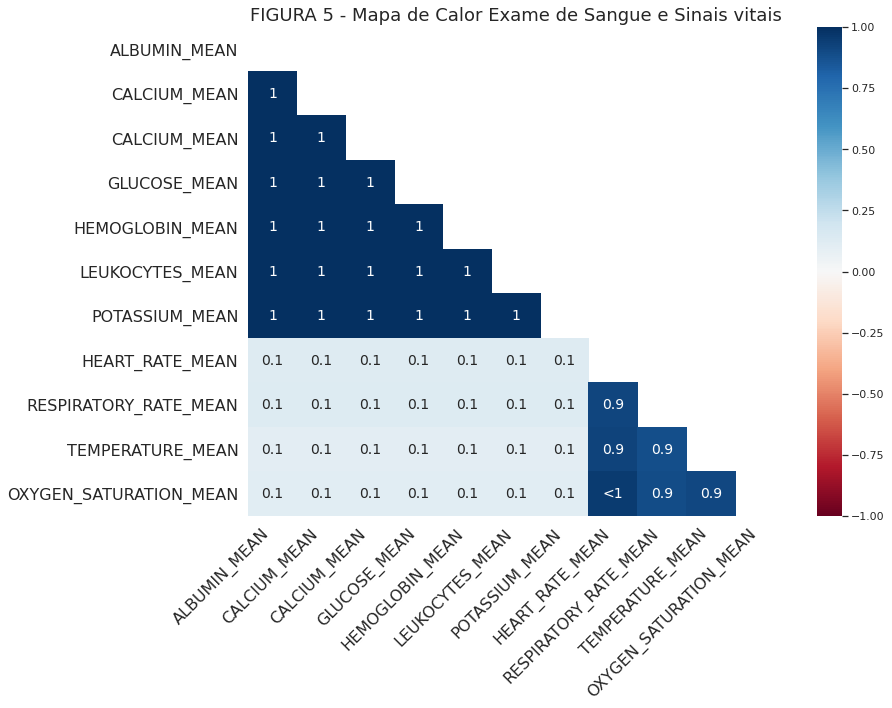

In [89]:
grafico_sang_resp = msno.heatmap(dados_sanguineos_respiracao,figsize=(12,9))
plt.title("FIGURA 5 - Mapa de Calor Exame de Sangue e Sinais vitais",size=18)
grafico_sang_resp.get_figure();

Acima temos que há correlação entre atributos que apresentam dados ausentes. Para os valores, temos a seguinte significação:

* Um valor próximo a  -1 (menos um) significa que se uma variável aparecer, é muito provável que a outra variável esteja ausente.
* Um valor próximo a 0 (zero) significa que não há dependência entre a ocorrência de valores ausentes de duas variáveis.
* Um valor próximo a 1 (um) significa que se uma variável aparecer, é muito provável que a outra variável esteja presente. 

No nosso caso, analisando essas colunas, conclui-se para a maioria das colunas possuem uma correlação positiva. Nos casos próximos a zero, temos que os valores  presentes ou ausentes não têm qualquer efeito uns sobre os outros.

Vamos utilizar um dendograma para entender melhor os agrupamentos (clusters) existentes nesse conjunto de dados que foi realizado. Por definição, um dendograma é:
>O dendrograma é um diagrama de árvore que exibe os grupos formados por agrupamento de observações em cada passo e em seus níveis de similaridade. O nível de similaridade é medido ao longo do eixo vertical (alternativamente, você pode exibir o nível de distância) e as diferentes observações são listadas ao longo do eixo horizontal.(Referência: [Minitab](https://support.minitab.com/pt-br/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/cluster-observations/interpret-the-results/all-statistics-and-graphs/dendrogram/))

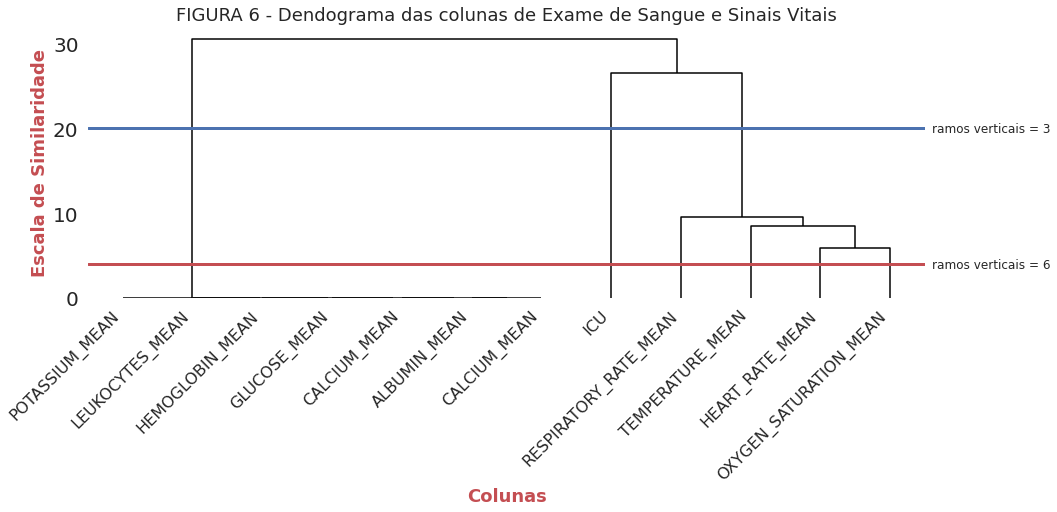

In [148]:
grafico_dendograma_sang_resp = msno.dendrogram(dados_sanguineos_respiracao,figsize=(15,5),orientation='top')
plt.ylabel("Escala de Similaridade",size=18,color='r',weight='bold')
plt.xlabel("Colunas",size=18,color='r',weight='bold')

plt.axhline(y=4,color='r',linewidth=3)
plt.text(138, 4, 'ramos verticais = 6', fontsize=12, va='center', ha='right', backgroundcolor='w')

plt.axhline(y=20,color='b',linewidth=3)
plt.text(138, 20, 'ramos verticais = 3', fontsize=12, va='center', ha='right', backgroundcolor='w')

plt.title("FIGURA 6 - Dendograma das colunas de Exame de Sangue e Sinais Vitais",size=18)
grafico_dendograma_sang_resp.get_figure();


A partir do gráfico podemos entender melhor quais colunas possuem uma similaridade mais próxima uma da outra. `HEART_RATE_MEAN` e `OXYGEN_SATURATION_MEAN` possuem bastante similaridade. Outro ponto interessante são os ramos verticais indicados no gráfico. Na linha de azul, temos 3 classes identificadas que vão se ramificando até gerarem no final, 6 classes. A classe da linha azul de número 3 (da esquerda para direita) é a responsável por agrupar informações de sinais vitais:
* `RESPIRATORY_RATE_MEAN`;
* `TEMPERATURE_MEAN`;
* `HEART_RATE_MEAN`;
* `OXYGEN_SATURATION_MEAN`.

Enquanto que na classe 1 da linha azul (da esquerda da direita), temos informaçõe referentes aos exames de sangue dos pacientes, por isso a similaridade deles estarem todas em um mesmo nível. O eixo y representa o limiar em alguma distância de linkagem. Por último, veja que `ICU`(coluna referente a UTI) possui sim um agrupamento em comum com os dados de sinais vitais em certo ponto, afinal, é apartir dos sinais vitais, da forma como eles estão, que podemos definir a necessidade de UTI, por exemplo (claro, é um dos fatores decisivos).

In [76]:
dfor i in list(dados.columns):
  print(i)

PATIENT_VISIT_IDENTIFIER
AGE_ABOVE65
AGE_PERCENTIL
GENDER
DISEASE GROUPING 1
DISEASE GROUPING 2
DISEASE GROUPING 3
DISEASE GROUPING 4
DISEASE GROUPING 5
DISEASE GROUPING 6
HTN
IMMUNOCOMPROMISED
OTHER
ALBUMIN_MEDIAN
ALBUMIN_MEAN
ALBUMIN_MIN
ALBUMIN_MAX
ALBUMIN_DIFF
BE_ARTERIAL_MEDIAN
BE_ARTERIAL_MEAN
BE_ARTERIAL_MIN
BE_ARTERIAL_MAX
BE_ARTERIAL_DIFF
BE_VENOUS_MEDIAN
BE_VENOUS_MEAN
BE_VENOUS_MIN
BE_VENOUS_MAX
BE_VENOUS_DIFF
BIC_ARTERIAL_MEDIAN
BIC_ARTERIAL_MEAN
BIC_ARTERIAL_MIN
BIC_ARTERIAL_MAX
BIC_ARTERIAL_DIFF
BIC_VENOUS_MEDIAN
BIC_VENOUS_MEAN
BIC_VENOUS_MIN
BIC_VENOUS_MAX
BIC_VENOUS_DIFF
BILLIRUBIN_MEDIAN
BILLIRUBIN_MEAN
BILLIRUBIN_MIN
BILLIRUBIN_MAX
BILLIRUBIN_DIFF
BLAST_MEDIAN
BLAST_MEAN
BLAST_MIN
BLAST_MAX
BLAST_DIFF
CALCIUM_MEDIAN
CALCIUM_MEAN
CALCIUM_MIN
CALCIUM_MAX
CALCIUM_DIFF
CREATININ_MEDIAN
CREATININ_MEAN
CREATININ_MIN
CREATININ_MAX
CREATININ_DIFF
FFA_MEDIAN
FFA_MEAN
FFA_MIN
FFA_MAX
FFA_DIFF
GGT_MEDIAN
GGT_MEAN
GGT_MIN
GGT_MAX
GGT_DIFF
GLUCOSE_MEDIAN
GLUCOSE_MEAN
GLUCOSE_MIN
